# Set-up

In [66]:
import wrds
import pandas as pd
import numpy as np
import os
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Get the current working directory
script_dir = os.getcwd()

# Set the working directory to the current script's directory (which in this case is already the working directory)
os.chdir(script_dir)

print(f"Working directory is set to: {script_dir}")

# Connect to WRDS
db = wrds.Connection(wrds_username='zrsong')

# Define the start and end dates
start_date = '2010-01-01'
end_date = '2024-06-30'

'''
# Use S&P ratings data as Compustat ratings data were discontinued in 2017
# Query the S&P ratings data
query = f"""
    SELECT gvkey, ratingdate, ratingsymbol
    FROM ciq_ratings.wrds_erating 
    WHERE ratingdate >= '{start_date}' AND ratingdate <= '{end_date}'
"""

# Execute the query and fetch the data
ratings_date = db.raw_sql(query)

# Save the data to a CSV file
ratings_date.to_csv('../Data/ratings_data.csv', index=False)
'''

Working directory is set to: /Users/zrsong/Dropbox (MIT)/Research Projects/Tax and M&A Debt/Code
Loading library list...
Done


'\n# Use S&P ratings data as Compustat ratings data were discontinued in 2017\n# Query the S&P ratings data\nquery = f"""\n    SELECT gvkey, ratingdate, ratingsymbol\n    FROM ciq_ratings.wrds_erating \n    WHERE ratingdate >= \'{start_date}\' AND ratingdate <= \'{end_date}\'\n"""\n\n# Execute the query and fetch the data\nratings_date = db.raw_sql(query)\n\n# Save the data to a CSV file\nratings_date.to_csv(\'../Data/ratings_data.csv\', index=False)\n'

# Compustat

In [ ]:
fund_table = 'funda'

varlist = ['conm', 'tic', 'cusip','fyear', 'fyr', 'at','capx', 'ceq', 'cogs', 'csho', 'dlc', 'dlcch','dltt', 'dp', 'ib', 'itcb', 
           'lt', 'mib', 'naicsh', 'ni', 'prstkcc', 'pstk', 'pstkl', 'pstkrv', 're', 'revt', 'sale', 'ebitda', 'dpc', 'oiadp', 'oibdp',
           'seq', 'sich', 'txdb', 'txdi', 'txditc', 'wcapch', 'xint', 'xlr', 'xrd', 'xsga', 'ppegt', 'xrd', 'ebit']

query = """SELECT gvkey, datadate, {}
           FROM comp.{}
           WHERE datafmt = 'STD'
           AND popsrc = 'D'
           AND indfmt = 'INDL'
           AND consol = 'C'
           AND fyear>=2010;""".format(", ".join(varlist), fund_table)

compa = db.raw_sql(query, date_cols=['datadate'])

del(fund_table, varlist, query)

In [77]:
# Import SIC codes from comp.company
sic_table = 'company'
query = "SELECT gvkey, sic FROM comp.company"
sic_codes = db.raw_sql(query)

# Merge SIC codes back to compa dataframe
compa = compa.merge(sic_codes, how='left', on='gvkey')

In [78]:
# all colnames of compa
# check if sic exists
# for each gvkey fyear, keep the one with the highest at
compa = compa.sort_values(['gvkey', 'fyear', 'at'], ascending=[True, True, False])
compa = compa.drop_duplicates(subset=['gvkey', 'fyear'], keep='first')

In [79]:
# missing values of ebitda (due to missing dp/oiabp)
compa['ebitda'] = compa['ebitda'].fillna(compa['ebit'] + compa['dp'])
# replace ebitda = ebit if ebitda is missing
compa['ebitda'] = compa['ebitda'].fillna(compa['ebit'])
# replace ebida = ni if ebitda is still missing
compa['ebitda'] = compa['ebitda'].fillna(compa['ni'])

In [80]:
# If there are missing values between years for ebitda, fill with average of prev and post years
compa['ebitda'] = compa['ebitda'].fillna((compa['ebitda'].shift(1) + compa['ebitda'].shift(-1)) / 2)
# fill with prev/post if there are consecutive missing values
compa['ebitda'] = compa['ebitda'].ffill().bfill()

In [81]:
# change gvkey to int
compa['gvkey'] = compa['gvkey'].astype(int)

In [82]:
# output csv. format
compa.to_csv("../Data/Raw/compustat_annual.csv", index=False)

In [105]:

# Quarterly Compustat data
fund_table = 'fundq'
varlist = ['gvkey', 'conm', 'tic', 'cusip','fyearq', 'fqtr', 'fyr', 'atq','capxy', 'ceqq', 'cogsq', 
           'cshoq', 'dlcq', 'dlcchy','dlttq', 'dpq', 'ibq', 'itccy', 'fic', 'pstkrq',
           'ltq', 'mibq', 'niq', 'prstkccy', 'pstkq', 'req', 'revtq', 'saleq',
           'seqq', 'txdbq', 'txdiq', 'txditcq', 'wcapchy', 'xinty', 'xrdq', 'xrdy', 'xsgaq',
           'mkvaltq', 'epspxq', 'epsfxq', 'ajexq', 'prccq', 'oancfy', 'ivncfy', 'rdq', 'ppegtq', 'ppentq']
# Join the list into a comma-separated string
varlist_str = ", ".join(varlist)
# use the varlist above to query quarterly compustat data (don't use join(varlist) as it will return a string)
query = f"""
    SELECT {varlist_str}
    FROM comp_na_daily_all.{fund_table}
    WHERE datadate >= '{start_date}' AND datadate <= '{end_date}'
"""
compq = db.raw_sql(query)

In [106]:
# How to deal with duplicates? Keep last available entry (datadate)
compq.dropna(subset=['fyearq', 'fqtr'], inplace=True)
compq.sort_values(['gvkey','fyearq', 'fqtr', 'atq'], inplace=True)
compq = compq[~compq.duplicated(['gvkey', 'fyearq', 'fqtr'], keep='last')]

In [107]:
duplicate_columns = compq.columns[compq.columns.duplicated()]
print("Duplicate columns:", duplicate_columns)

Duplicate columns: Index([], dtype='object')


In [108]:
# Calculating BE
# Shareholder Equity
compq['se'] = compq['seqq']
# Uses Common Equity (ceq) + Preferred Stock (pstk) if SEQ is missing:
compq['se'] = compq['se'].fillna(compq['ceqq'] + compq['pstkq'])
# Uses Total Assets (at) - Liabilities (lt) + Minority Interest (mib, if available), if others are missing
compq['se'] = compq['se'].fillna(compq['atq'] - compq['ltq'] + compq['mibq'].fillna(0))

In [109]:
# Preferred Stock
# Preferred Stock (Redemption Value)
compq['ps'] = compq['pstkrq']
# Uses Preferred Stock (Liquidating Value (pstkl)) if Preferred Stock (Redemption Value) is missing (pstkl doesnt' exist for quarterly data)
# compq['ps'] = compq['ps'].fillna(compq['pstkl'])
# Uses Preferred Stock (Carrying Value (pstk)) if others are missing
compq['ps'] = compq['ps'].fillna(compq['pstkq'])

In [110]:
# Deferred Taxes
# Uses Deferred Taxes and Investment Tax Credit (txditc)
compq['dt'] = compq['txditcq']
# This was Novy-Marx old legacy code. We drop this part to be in accordance with Ken French.
# Uses Deferred Taxes and Investment Tax Credit(txdb) + Investment Tax Credit (Balance Sheet) (itcb) if txditc is missing (itcb (Investment Tax Credit (Balance Sheet)) doesn't exist for quarterly data)
compq['dt'] = compq['dt'].fillna(compq['txdbq'].fillna(0))
# If all measures are missing, set to missing
compq.loc[pd.isnull(compq['txditcq']) & pd.isnull(compq['txdbq']), 'dt'] = np.nan

In [111]:
# Book Equity
# Book Equity (BE) = Share Equity (se) - Prefered Stocks (ps) + Deferred Taxes (dt)
compq['be'] = (compq['se']  # shareholder equity must be available, otherwise BE is missing
               - compq['ps']  # preferred stock must be available, otherwise BE is missing
               + compq['dt'].fillna(0))  # add deferred taxes if available
               #- compa['prba'].fillna(0))  # subtract postretirement benefit assets if available

In [112]:
# COST = COGS + XSGA + XINT 
compq['cost'] = compq[['cogsq', 'xsgaq', 'xinty']].sum(axis=1, skipna=True)
compq.loc[compq[['cogsq', 'xsgaq', 'xinty']].isnull().all(axis=1), 'cost'] = np.nan
# OP = SALE - COST    
compq['op'] = compq['saleq']-compq['cost']

In [113]:
# output csv. format
compq.to_csv("../Data/Raw/compustat_quarterly.csv", index=False)

# Dealscan

In [17]:
# Query the dealscan syndicated loan data
query = f"""
    SELECT *
    FROM tr_dealscan.dealscan
    WHERE deal_active_date >= '{start_date}' AND deal_active_date <= '{end_date}'
"""

# Execute the query and fetch the data
dealscan_data = db.raw_sql(query)
# Save the data to a CSV file
dealscan_data.to_csv('../Data/Raw/dealscan_data.csv', index=False)

In [50]:
# import dealscan data 
dealscan_data = pd.read_csv("../Data/Raw/dealscan_data.csv")

/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_65759/637324094.py:2: DtypeWarning: Columns (26,42,46,50,65,85,103,106,107,108,109,112,113,122,127,130,138,139,140,142,146,150,151,152,155,156,157,158,159,160,161,162,163,164,200,202) have mixed types. Specify dtype option on import or set low_memory=False.
  dealscan_data = pd.read_csv("../Data/Raw/dealscan_data.csv")


In [51]:
# Convert deal_active_date to datetime if it's not already
dealscan_data['deal_active_date'] = pd.to_datetime(dealscan_data['deal_active_date'])

# Filter the dataframe
dealscan_data = dealscan_data[dealscan_data['deal_active_date'] >= '2010-01-01']

# keep only county == "United States"
dealscan_data = dealscan_data[dealscan_data['country'] == 'United States']

# generate leveraged = 1 if the text "Leveraged" appears in market_segment
dealscan_data['leveraged'] = dealscan_data['market_segment'].str.contains("Leveraged", case=False, na=False).astype(int)

# generate year from deal_active_date
dealscan_data['year'] = dealscan_data['deal_active_date'].dt.year

In [52]:
def plot_dealcount(dealscan_data, label_name):
    # aggregate by lpc_tranche_id and tranche_permid
    collapsed_ds = dealscan_data.groupby(['lpc_deal_id']).agg({
        'deal_permid': 'first',
        'deal_active_date': 'min',
        'borrower_name': 'first',
        'borrower_id': 'first',
        'state_province': 'first',
        'country': 'first',
        'zip': 'first',
        'city': 'first',
        'sic_code': 'first',
        'sponsor': 'first',
        'lead_arranger': 'first',
        'number_of_lenders': 'first',
        'deal_amount': 'first',
        'deal_amount_converted': 'first',
        'deal_purpose': 'first',
        'deal_amended': 'first',
        'market_segment': 'first',
        'seniority_type': 'first',
        'secured': 'first',
        'margin_bps': 'first',
        'leveraged': 'first',
        'year': 'first',
    }).reset_index()

    # sort by lpc_deal_id and deal_active_date
    collapsed_ds = collapsed_ds.sort_values(['lpc_deal_id', 'deal_active_date'])

    # collapse dataset down by year leveraged
    deal_count = collapsed_ds.groupby(['year', 'leveraged']).agg({
        'lpc_deal_id': 'count',
    }).reset_index()

    # Assuming 'deal_count' contains the data
    sns.barplot(x='year', y='lpc_deal_id', hue='leveraged', data=deal_count, errorbar=None)

    # Add labels and a title
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Deal Count', fontsize=12)
    plt.title(f'LPC Deal Count by Year and Leveraged Status: {label_name}', fontsize=14)

    # Show the plot
    plt.tight_layout()
    plt.show()

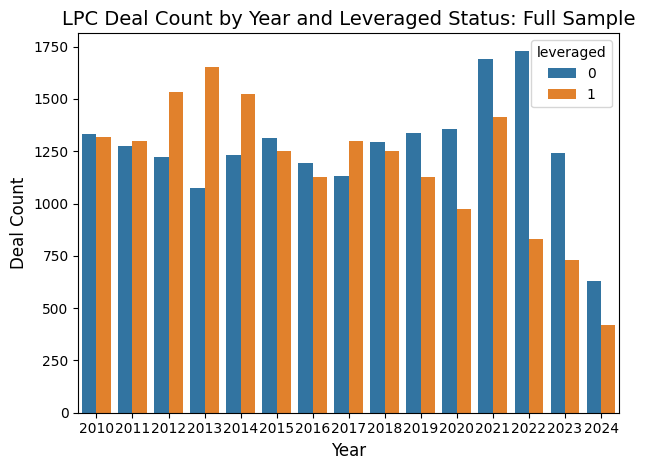

In [53]:
plot_dealcount(dealscan_data, 'Full Sample')

## Split by term loan and revolver

In [54]:
# generate term_loan = 1 if the text "Term Loan" appears in tranche type
dealscan_data['term_loan'] = dealscan_data['tranche_type'].str.contains("Term Loan", case=False, na=False).astype(int)
dealscan_data['revolver'] = dealscan_data['tranche_type'].str.contains("Revolver", case=False, na=False).astype(int)

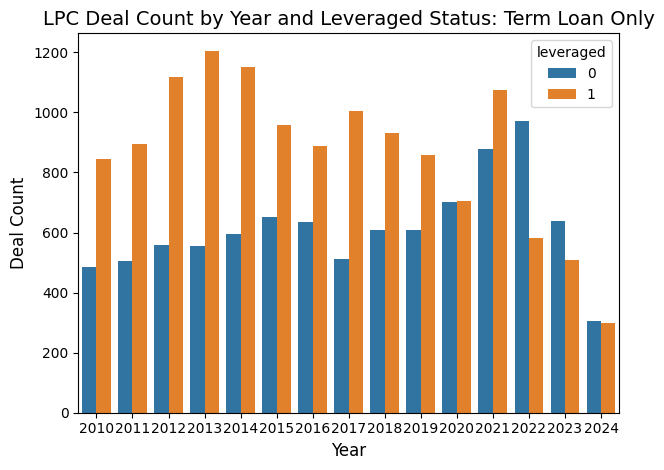

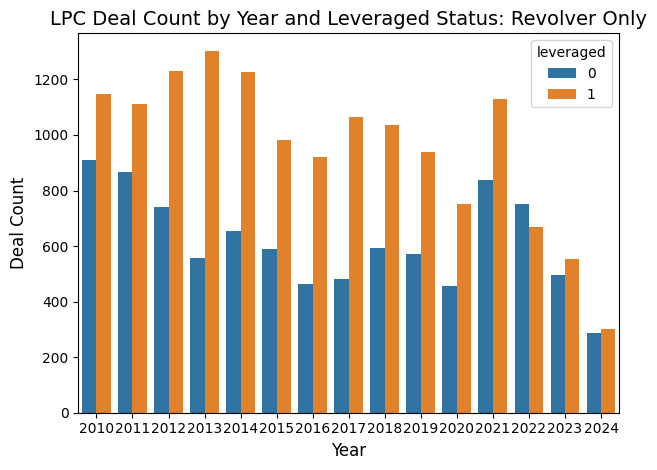

In [55]:
# plots for term_loan only
dealscan_data_term_loan = dealscan_data[dealscan_data['term_loan'] == 1]
plot_dealcount(dealscan_data_term_loan, 'Term Loan Only')

# plots for revolver only
dealscan_data_revolver = dealscan_data[dealscan_data['revolver'] == 1]
plot_dealcount(dealscan_data_revolver, 'Revolver Only')

## Merge with Compustat

In [56]:
dealscan_new_legacy_link = pd.read_excel('../Data/Raw/WRDS_to_LoanConnector_IDs.xlsx')

# Rename columns to lpc_deal_id, packageid, lpc_tranche_id, facilityid
dealscan_new_legacy_link.columns = ['lpc_deal_id', 'packageid', 'lpc_tranche_id', 'facilityid']

# Identify duplicates in the combination of 'lpc_deal_id' and 'lpc_tranche_id'
dealscan_new_legacy_link['dup'] = dealscan_new_legacy_link.duplicated(subset=['lpc_deal_id', 'lpc_tranche_id'], keep=False).astype(int)

# Drop rows where duplicates exist (i.e., 'dup' != 0)
dealscan_new_legacy_link = dealscan_new_legacy_link[dealscan_new_legacy_link['dup'] == 0]

# Drop the 'dup' column (no longer needed)
dealscan_new_legacy_link = dealscan_new_legacy_link.drop(columns=['dup'])

In [57]:
# merge with dealscan_data on lpc_deal_id and lpc_tranche_id
dealscan_merged = dealscan_data.merge(dealscan_new_legacy_link, on=['lpc_deal_id', 'lpc_tranche_id'], how='inner')

In [ ]:
dealscan_compustat_link = pd.read_excel('../Data/Raw/Dealscan-Compustat_Linking_Database012024.xlsx', sheet_name = 'links')

dealscan_merged = dealscan_merged.merge(dealscan_compustat_link, on='facilityid', how='inner')

# merge gvkey with compustat annual data for now 
dealscan_merged['fyear'] = dealscan_merged['year']
dealscan_compa_merged = dealscan_merged.merge(compa, on=['gvkey', 'fyear'], how='inner')

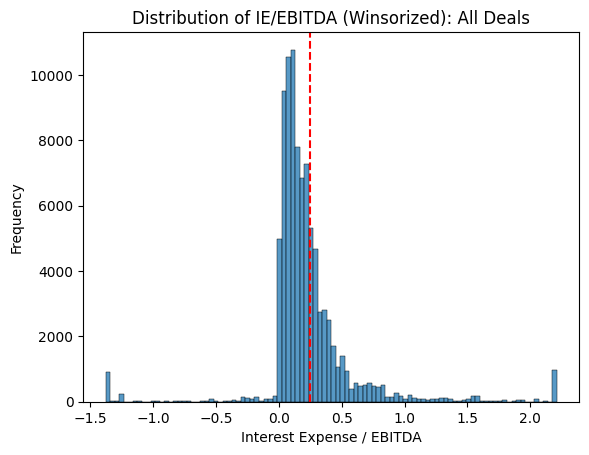

In [103]:
# calculate the interest coverage ratio
dealscan_compa_merged['interest_expense_by_ebitda'] = dealscan_compa_merged['xint'] / dealscan_compa_merged['ebitda']
# describe the interest coverage ratio
dealscan_compa_merged['interest_expense_by_ebitda'].describe()
# plot the histogram of winsorized interest_expense_by_ebitda
interest_expense_winsorized = dealscan_compa_merged['interest_expense_by_ebitda'].clip(dealscan_compa_merged['interest_expense_by_ebitda'].quantile(0.01), dealscan_compa_merged['interest_expense_by_ebitda'].quantile(0.99))
sns.histplot(interest_expense_winsorized, bins=100)
plt.axvline(x=0.25, color='r', linestyle='--')
plt.xlabel('Interest Expense / EBITDA')
plt.ylabel('Frequency')
plt.title('Distribution of IE/EBITDA (Winsorized): All Deals')
plt.show()



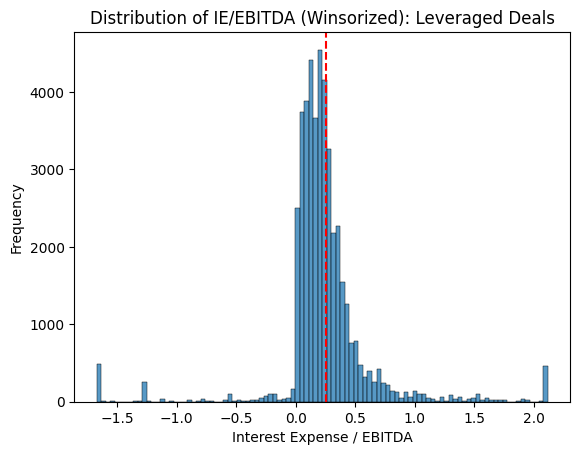

In [104]:
# keep only leveraged deals
leveraged_compa_merged = dealscan_compa_merged[dealscan_compa_merged['leveraged'] == 1]
# do the same plot as above but after winsorizing the interest coverage ratio at 1% and 99%
interest_expense_winsorized = leveraged_compa_merged['interest_expense_by_ebitda'].clip(leveraged_compa_merged['interest_expense_by_ebitda'].quantile(0.01), leveraged_compa_merged['interest_expense_by_ebitda'].quantile(0.99))
sns.histplot(interest_expense_winsorized, bins=100)
plt.axvline(x=0.25, color='r', linestyle='--')
plt.xlabel('Interest Expense / EBITDA')
plt.ylabel('Frequency')
plt.title('Distribution of IE/EBITDA (Winsorized): Leveraged Deals')
plt.show()

In [59]:
# obtain Dealscan legacy lenders data (to use 2018 JF bank name link)
#query = f"""
#    SELECT *
#    FROM tr_dealscan.lendershares
#"""
#lendershares = db.raw_sql(query)

# output csv. format
#lendershares.to_csv("../Data/Raw/lendershares.csv", index=False)